In [1]:
import sys
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
sys.path.append('..')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

# Model Results Analysis and Comparison

**Purpose:** This notebook provides a comprehensive comparison of all trained models, evaluating their performance, efficiency, and resource utilization to identify the best architecture for the Tiny ImageNet-200 task.

**Key Analyses:**
- Test accuracy comparison across all models
- Model complexity vs. performance trade-offs
- Training efficiency and resource usage
- Overall model rankings and recommendations

In [2]:
# Load model architectures to get parameter counts
sys.path.append("../src")
from models.alexnet import AlexNet
from models.resnet18 import ResNet18
from models.densenet121 import DenseNet121
from models.vgg16 import VGG16
from models.vit_s_16 import ViT_S_16
from models.efficientnet_b0 import EfficientNetB0
import os

model_architectures = {
    "alexnet": AlexNet(num_classes=200),
    "resnet": ResNet18(num_classes=200),
    "densenet": DenseNet121(num_classes=200),
    "vgg": VGG16(num_classes=200),
    "vit": ViT_S_16(num_classes=200),
    "efficientnet": EfficientNetB0(num_classes=200),
}

In [3]:
# Load all results
def load_all_results(results_dir="../results"):
    """Load all model results"""
    results_path = Path(results_dir)
    all_data = {}

    for model_dir in results_path.iterdir():
        if model_dir.is_dir() and not model_dir.name.startswith("."):
            model_name = model_dir.name

            test_file = model_dir / "test_results.json"
            history_file = model_dir / "history.json"

            if test_file.exists() and history_file.exists():
                with open(test_file, "r") as f:
                    test_data = json.load(f)
                with open(history_file, "r") as f:
                    history_data = json.load(f)

                all_data[model_name] = {"test": test_data, "history": history_data}

    return all_data


all_results = load_all_results()

In [4]:
# Build comprehensive comparison
comprehensive_data = []

for model_name, data in all_results.items():
    test = data["test"]
    history = data["history"]
    config = history.get("config", {})

    # Get model architecture
    model = model_architectures.get(model_name)
    params = sum(p.numel() for p in model.parameters()) if model else 0
    params_m = params / 1e6

    # Performance metrics
    test_acc = test.get("test_acc", 0)
    test_top5 = test.get("test_top5_acc", 0)
    best_val_acc = max(history.get("val_acc", [0]))

    # Training metrics
    final_train_acc = history["train_acc"][-1] if history.get("train_acc") else 0
    final_val_acc = history["val_acc"][-1] if history.get("val_acc") else 0
    train_val_gap = final_train_acc - final_val_acc

    # Resource metrics
    training_time = history.get("total_training_time_hours", 0)
    peak_memory_mb = history.get("peak_training_memory_mb", 0)
    peak_memory_gb = peak_memory_mb / 1024

    # Training config
    total_epochs = config.get("epochs", 0)
    batch_size = config.get("batch_size", 0)
    optimizer = config.get("optimizer", "N/A")
    scheduler = config.get("scheduler", "N/A")
    mixup_alpha = config.get("mixup_cutmix_alpha", 0.0)

    # Learning rate
    initial_lr = history["lr"][0] if history.get("lr") and len(history["lr"]) > 0 else 0

    # Trained model size (checkpoint file)
    checkpoint_path = f"../results/{model_name}/best_model.pth"
    checkpoint_size_mb = 0
    if os.path.exists(checkpoint_path):
        checkpoint_size_mb = os.path.getsize(checkpoint_path) / (1024**2)

    # Efficiency metrics
    acc_per_hour = test_acc / training_time if training_time > 0 else 0
    acc_per_m_params = test_acc / params_m if params_m > 0 else 0
    acc_per_gb = test_acc / peak_memory_gb if peak_memory_gb > 0 else 0

    comprehensive_data.append(
        {
            "Model": model_name,
            "Params (M)": params_m,
            "Size (MB)": checkpoint_size_mb,
            "Test Acc (%)": test_acc,
            "Test Top-5 Acc (%)": test_top5,
            "Best Val Acc (%)": best_val_acc,
            "Final Train Acc (%)": final_train_acc,
            "Final Val Acc (%)": final_val_acc,
            "Train-Val Gap (%)": train_val_gap,
            "Total Epochs": total_epochs,
            "Batch Size": batch_size,
            "Optimizer": optimizer,
            "Scheduler": scheduler,
            "Initial LR": initial_lr,
            "MixUp/CutMix Alpha": mixup_alpha,
            "Training Time (hrs)": training_time,
            "Memory (MB)": peak_memory_mb,
            "Memory (GB)": peak_memory_gb,
            "Efficiency (acc/hr)": acc_per_hour,
            "Param Efficiency (acc/M)": acc_per_m_params,
            "Memory Efficiency (acc/GB)": acc_per_gb,
        }
    )

comprehensive_df = pd.DataFrame(comprehensive_data)
comprehensive_df = comprehensive_df.sort_values("Test Acc (%)", ascending=False)
comprehensive_df.to_csv("../results/model_comparison.csv", index=False)
comprehensive_df

,Model,Params (M),Size (MB),Test Acc (%),Test Top-5 Acc (%),Best Val Acc (%),Final Train Acc (%),Final Val Acc (%),Train-Val Gap (%),Total Epochs,...,Optimizer,Scheduler,Initial LR,MixUp/CutMix Alpha,Training Time (hrs),Memory (MB),Memory (GB),Efficiency (acc/hr),Param Efficiency (acc/M),Memory Efficiency (acc/GB)
1,resnet,11.271432,86.086233,64.01,85.52,64.755,60.51875,64.755,-4.23625,80,...,sgd,cosine,0.100000,0.4,30.077112,3964.812500,3.871887,2.128196,5.678959,16.531990
5,vgg,14.825736,113.186906,60.58,82.90,60.605,61.72875,60.605,1.12375,80,...,sgd,cosine,0.100000,0.4,23.553560,2978.765625,2.908951,2.572010,4.086138,20.825378
0,densenet,2.240972,17.406405,52.56,78.00,51.610,53.40125,51.610,1.79125,50,...,sgd,cosine,0.100000,0.0,24.441899,13114.406250,12.807037,2.150406,23.454108,4.103994
4,alexnet,15.727368,120.019136,51.09,76.65,51.455,53.92000,51.400,2.52000,100,...,sgd,cosine,0.100000,0.0,16.131461,2756.484375,2.691879,3.167103,3.248477,18.979306
2,efficientnet,4.457796,34.349674,38.63,65.77,40.145,48.80875,39.345,9.46375,40,...,sgd,cosine,0.100000,0.0,2.047195,2027.703125,1.980179,18.869718,8.665717,19.508339
3,vit,21.627080,247.684184,26.64,52.83,27.330,32.01750,27.040,4.97750,100,...,adamw,cosine,0.000001,0.0,21.586973,8594.859375,8.393417,1.234078,1.231789,3.173916


## 1. Train-Val-Test Accuracy Comparison

Grouped bar chart comparing final training, validation, and test accuracies across models. This helps identify generalization gaps and whether models perform consistently across all splits.

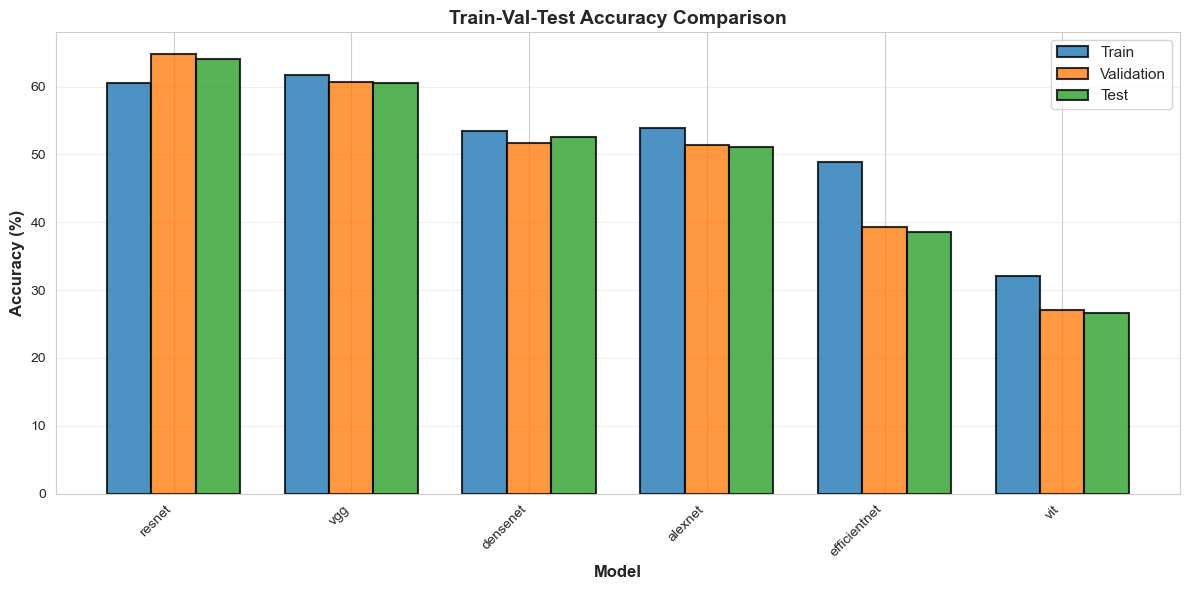

In [5]:
# Train-Val-Test Grouped Bar Chart
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

models = comprehensive_df['Model'].values
train_acc = comprehensive_df['Final Train Acc (%)'].values
val_acc = comprehensive_df['Final Val Acc (%)'].values
test_acc = comprehensive_df['Test Acc (%)'].values

x = np.arange(len(models))
width = 0.25

bars1 = ax.bar(x - width, train_acc, width, label='Train', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x, val_acc, width, label='Validation', alpha=0.8, edgecolor='black', linewidth=1.5)
bars3 = ax.bar(x + width, test_acc, width, label='Test', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Train-Val-Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 2. Top-1 vs Top-5 Accuracy Comparison

Compares Top-1 (exact prediction) and Top-5 (correct class in top 5 predictions) accuracy across models. The gap between these metrics indicates model confidence and ranking quality.

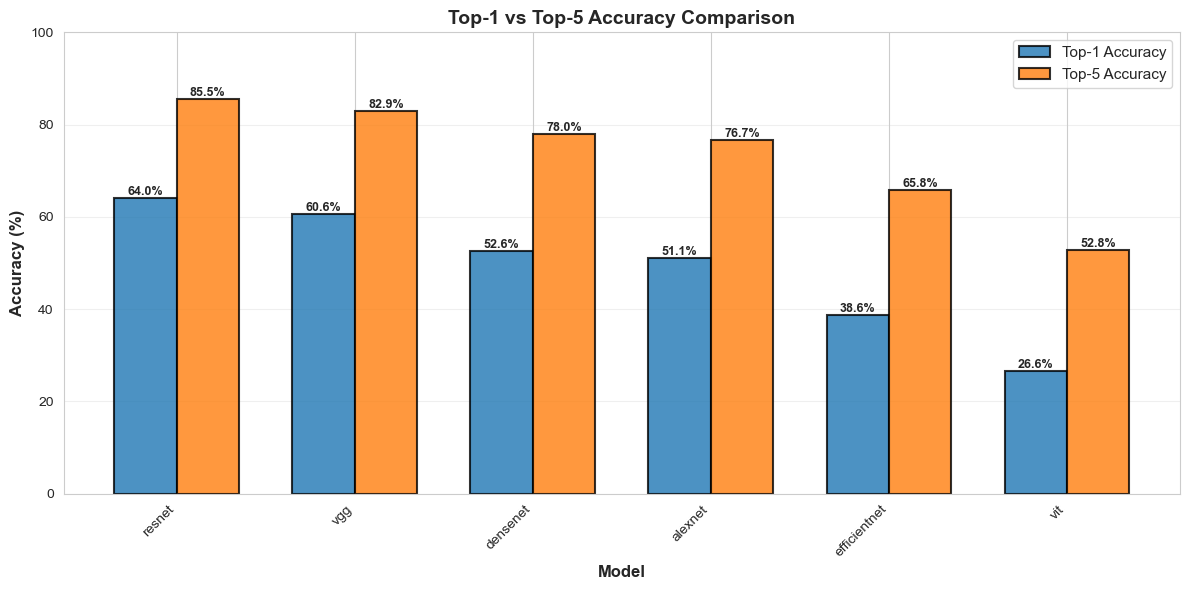

In [6]:
# Top-1 vs Top-5 Accuracy Comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

models = comprehensive_df['Model'].values
top1_acc = comprehensive_df['Test Acc (%)'].values
top5_acc = comprehensive_df['Test Top-5 Acc (%)'].values

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, top1_acc, width, label='Top-1 Accuracy', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, top5_acc, width, label='Top-5 Accuracy', alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Top-1 vs Top-5 Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

## 3. Efficiency and trade-offs

### 3.1 Accuracy vs. Model Parameters

Scatter plot showing the relationship between model complexity (parameter count) and test accuracy. This reveals parameter efficiency across architectures.

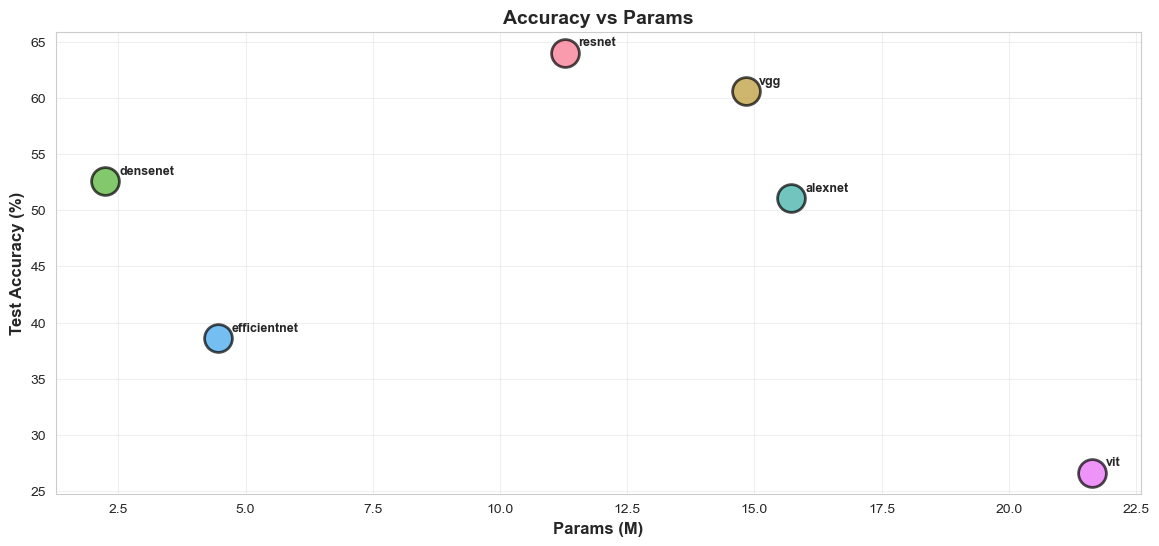

In [7]:
fig, ax = plt.subplots(1, 1)
colors = sns.color_palette("husl", len(comprehensive_df))
color_map = {model: color for model, color in zip(comprehensive_df['Model'], colors)}

for idx, row in comprehensive_df.iterrows():
    ax.scatter(row['Params (M)'], row['Test Acc (%)'], 
                      s=400, alpha=0.7, edgecolors='black', linewidth=2,
                      color=color_map[row['Model']])
    ax.annotate(row['Model'], (row['Params (M)'], row['Test Acc (%)']),
                       xytext=(10, 5), textcoords='offset points', fontsize=9, fontweight='bold')
ax.set_xlabel('Params (M)', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Accuracy vs Params', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

### 3.2 Accuracy vs. Training Time

Evaluates training efficiency by plotting accuracy against total training time. This helps identify which models offer the best accuracy-to-time trade-off.

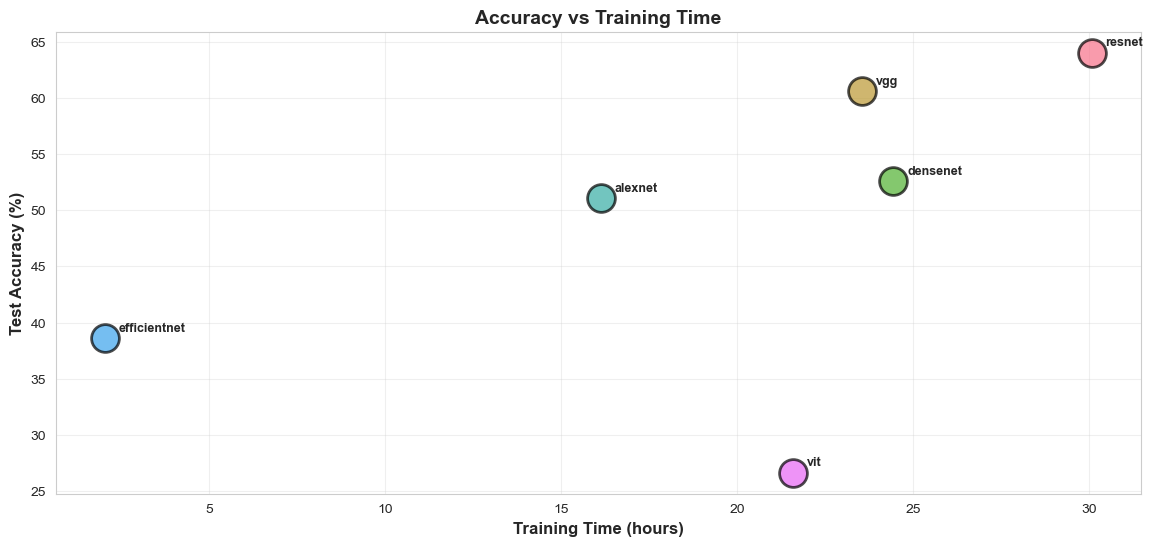

In [8]:
fig, ax = plt.subplots(1, 1)
colors = sns.color_palette("husl", len(comprehensive_df))
color_map = {model: color for model, color in zip(comprehensive_df['Model'], colors)}

for idx, row in comprehensive_df.iterrows():
    ax.scatter(row['Training Time (hrs)'], row['Test Acc (%)'], 
                      s=400, alpha=0.7, edgecolors='black', linewidth=2,
                      color=color_map[row['Model']])
    ax.annotate(row['Model'], (row['Training Time (hrs)'], row['Test Acc (%)']),
                       xytext=(10, 5), textcoords='offset points', fontsize=9, fontweight='bold')
ax.set_xlabel('Training Time (hours)', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Accuracy vs Training Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

### 3.3 Accuracy vs. Memory Usage

Analyzes the relationship between peak training memory consumption and model accuracy. This metric is crucial for deployment constraints and batch size decisions.

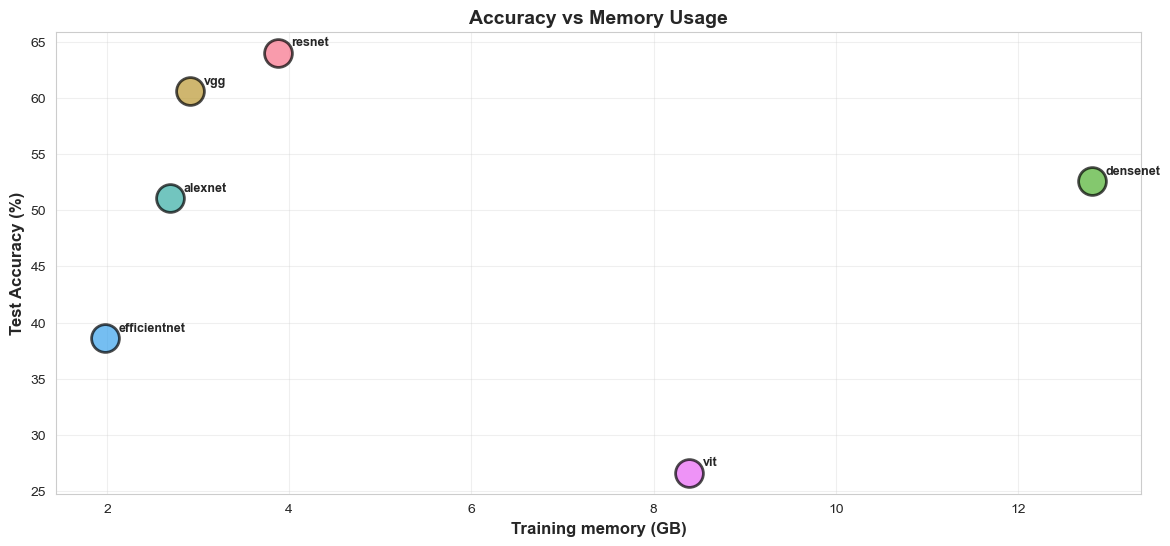

In [9]:
fig, ax = plt.subplots(1, 1)
colors = sns.color_palette("husl", len(comprehensive_df))
color_map = {model: color for model, color in zip(comprehensive_df['Model'], colors)}

for idx, row in comprehensive_df.iterrows():
    ax.scatter(row['Memory (GB)'], row['Test Acc (%)'], 
                      s=400, alpha=0.7, edgecolors='black', linewidth=2,
                      color=color_map[row['Model']])
    ax.annotate(row['Model'], (row['Memory (GB)'], row['Test Acc (%)']),
                       xytext=(10, 5), textcoords='offset points', fontsize=9, fontweight='bold')
ax.set_xlabel('Training memory (GB)', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Accuracy vs Memory Usage', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

### 3.4 Accuracy vs. Model Size

Compares model checkpoint file sizes (saved weights) against accuracy. This reveals the storage-to-accuracy trade-off for deployment.

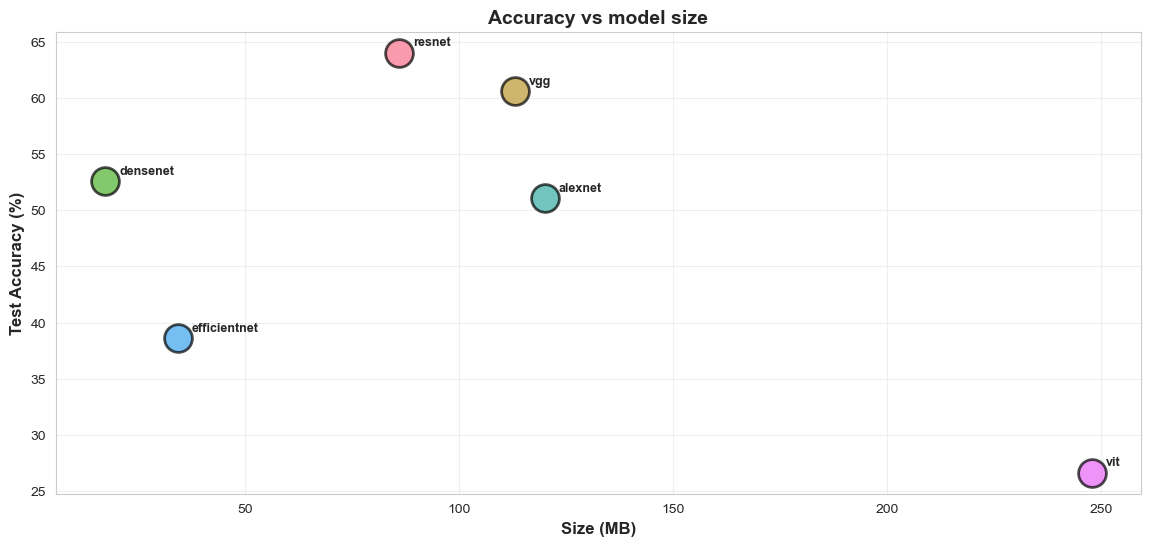

In [10]:
fig, ax = plt.subplots(1, 1)
colors = sns.color_palette("husl", len(comprehensive_df))
color_map = {model: color for model, color in zip(comprehensive_df['Model'], colors)}

for idx, row in comprehensive_df.iterrows():
    ax.scatter(row['Size (MB)'], row['Test Acc (%)'], 
                      s=400, alpha=0.7, edgecolors='black', linewidth=2,
                      color=color_map[row['Model']])
    ax.annotate(row['Model'], (row['Size (MB)'], row['Test Acc (%)']),
                       xytext=(10, 5), textcoords='offset points', fontsize=9, fontweight='bold')
ax.set_xlabel('Size (MB)', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Accuracy vs model size', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)